In [1]:
import pennylane as qml
import pennylane.numpy as np
import numpy as illegal_but_typed_np
from numpy.typing import NDArray

## 1. Set up circuit to optimize

In [2]:
from circuits import sim_02, sim_03, sim_04, sim_05

num_layers = 5
num_qubits = 4

# works as expected!
# circuit = sim_02(num_layers, num_qubits)
# initial_params = (
#     np.array(np.random.random((num_layers, num_qubits, 2))),
#     np.array([])
# )

# works as expected!
# circuit = sim_03(num_layers, num_qubits)
# initial_params = (
#     np.array(np.random.random((num_layers, num_qubits, 2))),
#     np.array(np.random.random((num_layers, num_qubits - 1)))
# )

circuit = sim_04(num_layers, num_qubits)
initial_params = (
    np.array(np.random.random((num_layers, num_qubits, 2))),
    np.array(np.random.random((num_layers, num_qubits - 1)))
)

# takes a long time and produces numerical errors
# circuit = sim_05(num_layers, num_qubits)
# initial_params = (
#     np.array(np.random.random((num_layers, num_qubits, 4))),
#     np.array(np.random.random((num_layers, num_qubits, num_qubits - 1)))
# )

print(qml.draw(circuit)(*initial_params))

# demo circuit from Rotosolve docs, crotosolve cannot solve this
# dev = qml.device('default.qubit', wires=3, shots=None)
# @qml.qnode(dev)
# def circuit(rot_param: NDArray, layer_param: float, crot_param: NDArray):
#     for i, par in enumerate(rot_param):
#         qml.RX(par, wires=i)
#     for w in dev.wires:
#         qml.RX(layer_param, wires=w)
#     for i, par in enumerate(crot_param):
#         qml.CRY(par, wires=[i, (i+1) % 3])
#     return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))
# params = (
#     np.array([0.3, 0.2, 0.67], requires_grad=True),
#     np.array(1.1, requires_grad=True),
#     np.array([-0.2, 0.1, -2.5], requires_grad=True)
# )

0: ──RX(0.50)──RZ(0.13)─────────────────────╭RX(0.47)──||──RX(0.78)──RZ(0.57)────────────────────
1: ──RX(0.06)──RZ(0.25)───────────╭RX(0.33)─╰●─────────||──RX(0.30)──RZ(0.09)───────────╭RX(0.74)
2: ──RX(0.42)──RZ(0.13)─╭RX(0.63)─╰●───────────────────||──RX(0.36)──RZ(0.56)─╭RX(0.12)─╰●───────
3: ──RX(0.47)──RZ(0.62)─╰●─────────────────────────────||──RX(0.88)──RZ(0.03)─╰●─────────────────

──╭RX(0.86)──||──RX(0.21)──RZ(0.69)─────────────────────╭RX(0.45)──||──RX(0.51)──RZ(0.12)──────────
──╰●─────────||──RX(0.22)──RZ(0.90)───────────╭RX(0.39)─╰●─────────||──RX(0.48)──RZ(0.77)──────────
─────────────||──RX(0.86)──RZ(0.13)─╭RX(0.12)─╰●───────────────────||──RX(0.99)──RZ(0.21)─╭RX(0.16)
─────────────||──RX(0.16)──RZ(0.88)─╰●─────────────────────────────||──RX(0.39)──RZ(0.95)─╰●───────

────────────╭RX(0.92)──||──RX(0.23)──RZ(0.29)─────────────────────╭RX(0.54)──||─┤  <Z>
──╭RX(0.16)─╰●─────────||──RX(0.16)──RZ(0.06)───────────╭RX(0.93)─╰●─────────||─┤     
──╰●───────────────────||──RX(0.

## 2. Run optimizations

In [3]:
from optimizers import (
    OptimizationTask,
    OptimizationResult,
    optimize_rotosolve,
    optimize_crotosolve,
    optimizers
)

task = OptimizationTask(circuit=circuit, initial_params=initial_params)

results: dict[str, OptimizationResult] = {}
my_optimizers = [
    ("Crotosolve", optimize_crotosolve),
    ("Rotosolve", optimize_rotosolve)
]
for name, optimize in my_optimizers:
    print(f"Optimizing with {name}...")
    result = optimize(task)
    results[name] = result

Optimizing with Crotosolve...
yodl
yodl
yodl
yodl
yodl
yodl
yodl
yodl
yodl
Optimizing with Rotosolve...


## 3. Plot loss curve

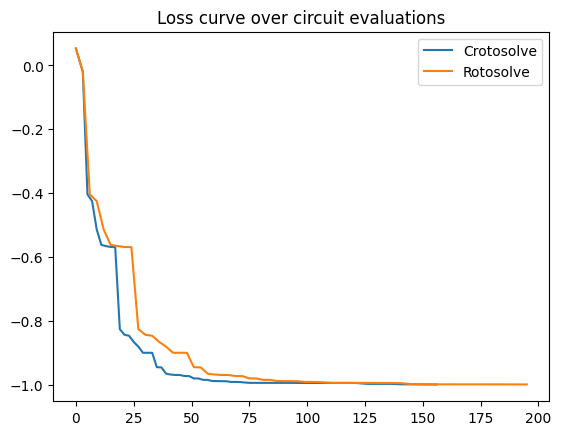

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title("Loss curve over circuit evaluations")

for optimizer_name, result in results.items():
    x, y = zip(*result.loss) # this unzips the list of points

    ax.plot(x, y, label=f"{optimizer_name}")
    ax.legend()

## 4. Save data to disk

In [5]:
import pickle

file = "./sim04_results2.pickle"

pickle.dump(results, open(file, "wb"))

# results = pickle.load(open(file, "rb"))